In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the file paths
train_files = ['own/data-int/1.csv', 'own/data-int/2.csv', 'own/data-int/4.csv']
validation_test_file = 'own/data-int/5.csv'

# Function to load and preprocess data
def load_and_preprocess_data(train_files, validation_test_file):
    # Load the training data
    train_dfs = [pd.read_csv(file) for file in train_files]
    
    # Load the validation and test data
    validation_test_df = pd.read_csv(validation_test_file)
    
    # Convert 'date/time' columns to datetime
    for df in train_dfs:
        df['datetime'] = pd.to_datetime(df['date/time'], errors='coerce')
    validation_test_df['datetime'] = pd.to_datetime(validation_test_df['date/time'], errors='coerce')
    
    # Process each training dataframe
    processed_train_dfs = []
    for df, file in zip(train_dfs, train_files):
        if '1.csv' in file:
            # Remove the first 1 minute and the last 3 minutes from the first training data (1.csv)
            train_start_time = df['datetime'].min() + pd.Timedelta(minutes=1)
            train_end_time = df['datetime'].max() - pd.Timedelta(minutes=3)
        elif '2.csv' in file:
            # Remove the first 3 minutes and the last 2.5 minutes from the second training data (2.csv)
            train_start_time = df['datetime'].min() + pd.Timedelta(minutes=3)
            train_end_time = df['datetime'].max() - pd.Timedelta(minutes=2.5)
        else:
            # Remove the first and last 1.5 minutes from the other training data (4.csv)
            train_start_time = df['datetime'].min() + pd.Timedelta(minutes=1.5)
            train_end_time = df['datetime'].max() - pd.Timedelta(minutes=1.5)
        processed_df = df[(df['datetime'] >= train_start_time) & (df['datetime'] <= train_end_time)]
        processed_train_dfs.append(processed_df)
    
    # Concatenate all processed training dataframes
    train_df = pd.concat(processed_train_dfs, ignore_index=True)
    
    # Split validation_test_df into validation and test sets
    mid_index = len(validation_test_df) // 2
    val_df = validation_test_df.iloc[:mid_index]
    test_df = validation_test_df.iloc[mid_index:]
    
    return train_df, val_df, test_df

# Load datasets
train_df, val_df, test_df = load_and_preprocess_data(train_files, validation_test_file)

print('Loading complete')
train_df.head(), val_df.head(), test_df.head()


2024-06-25 15:22:36.581425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 15:22:37.226916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-25 15:22:37.226990: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-

Loading complete


(                    date/time     gyro_x    gyro_y    gyro_z   accel_x  \
 0  2024-06-05 14:09:12.810708  47.229008  1.580153  4.488550  0.464475   
 1  2024-06-05 14:09:12.818031  47.030534  0.419847  5.343511 -0.964863   
 2  2024-06-05 14:09:12.824984  47.328244 -4.145038  6.557252 -0.799663   
 3  2024-06-05 14:09:12.832316  48.068702 -3.725191  6.763359  1.841141   
 4  2024-06-05 14:09:12.839155  47.679389 -1.847328  6.595420  3.287239   
 
     accel_y    accel_z          x          y                   timestamp  \
 0  0.493206   7.393295  24.801591  53.530177  2024-06-05 14:09:12.810708   
 1  0.105345   7.541735  24.776822  53.538791  2024-06-05 14:09:12.818031   
 2  0.849942   8.384494  24.752052  53.547405  2024-06-05 14:09:12.824984   
 3  0.289698  10.572795  24.727283  53.556018  2024-06-05 14:09:12.832316   
 4  0.694318  11.298238  24.702514  53.564632  2024-06-05 14:09:12.839155   
 
       x_cam     y_cam     z_cam                   datetime  
 0  0.469269 -0.780899

In [3]:
# Define features and targets
features = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z', 'x_cam', 'y_cam', 'z_cam']
targets = ['x', 'y']

# Scale the features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[features])
val_X_scaled = scaler.transform(val_df[features])
test_X_scaled = scaler.transform(test_df[features])

# Extract target values
train_y = train_df[targets].values
val_y = val_df[targets].values
test_y = test_df[targets].values

# Convert the data into sequences
def create_sequences(data, truth, sequence_length=100):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(truth[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 100
X_train, y_train = create_sequences(train_X_scaled, train_y, sequence_length)
X_val, y_val = create_sequences(val_X_scaled, val_y, sequence_length)
X_test, y_test = create_sequences(test_X_scaled, test_y, sequence_length)

print('Input sequences complete')


Input sequences complete


In [3]:
# Define the model with fewer layers to reduce overfitting
model = Sequential([
    Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(sequence_length, len(features))),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(12, return_sequences=True, kernel_regularizer='l2'),
    BatchNormalization(),
    LSTM(12, kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(12, activation='relu', kernel_regularizer='l2'),
    Dense(len(targets))
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError(name='rmse')])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f'Test RMSE: {test_rmse:.4f} meters')

# Export the model
model.save('trajectory_model7i.h5')

2024-06-14 11:34:23.580553: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: /usr/lib/x86_64-linux-gnu/libcuda.so.1: file too short; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-14 11:34:23.580577: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 8)             224       
                                                                 
 batch_normalization (BatchN  (None, 98, 8)            32        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 8)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 8)             0         
                                                                 
 lstm (LSTM)                 (None, 49, 12)            1008      
                                                                 
 batch_normalization_1 (Batc  (None, 49, 12)           4

2024-06-27 11:38:40.592986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: /usr/lib/x86_64-linux-gnu/libcuda.so.1: file too short; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-27 11:38:40.593020: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


4027/4027 [==============================] - 36s 9ms/step


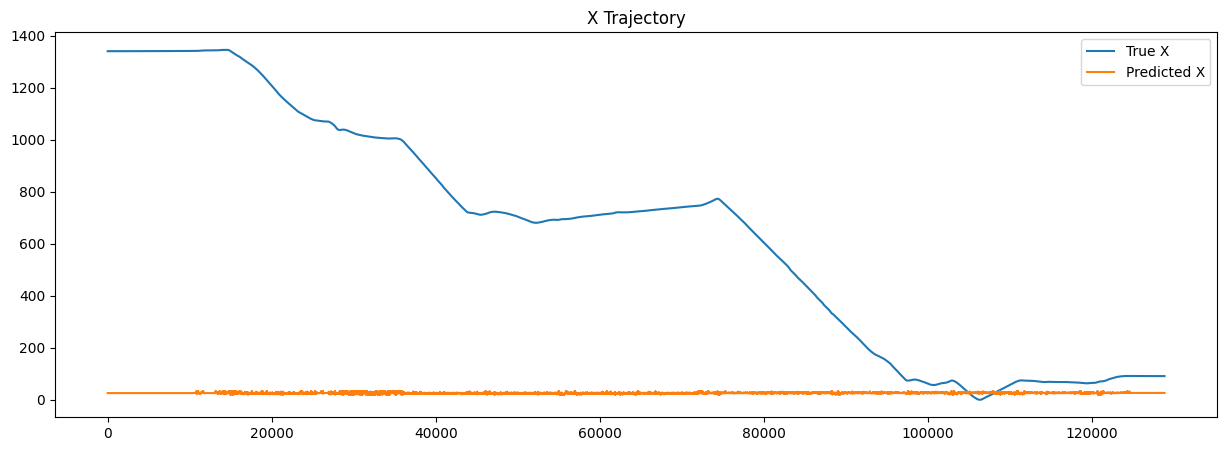

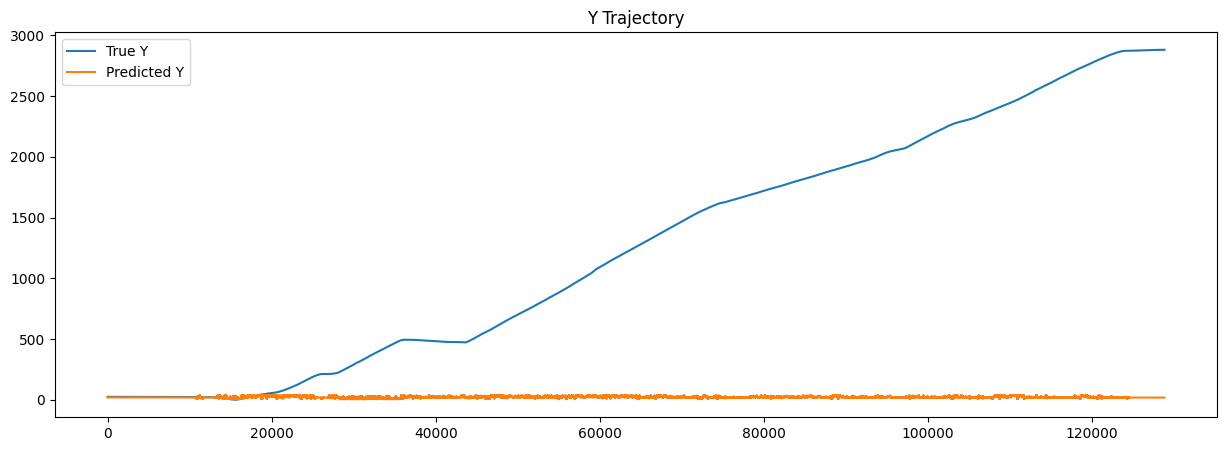

In [4]:
from tensorflow.keras.models import load_model

# Load the model and test it
loaded_model = load_model('trajectory_model7i.h5')

# Predict using the test data
y_pred = loaded_model.predict(X_test)

# Create a DataFrame to store the true and predicted values
data = {
    'true_x': y_test[:, 0],
    'predicted_x': y_pred[:, 0],
    'true_y': y_test[:, 1],
    'predicted_y': y_pred[:, 1]
}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('trajectory_predictions7i-6.csv', index=False)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
plt.plot(y_pred[:, 0], label='Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
plt.plot(y_pred[:, 1], label='Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()

3162/3162 [==============================] - 22s 7ms/step
RMSE before filtering: 14.246906003984227
RMSE after filtering: 13.570064545226039


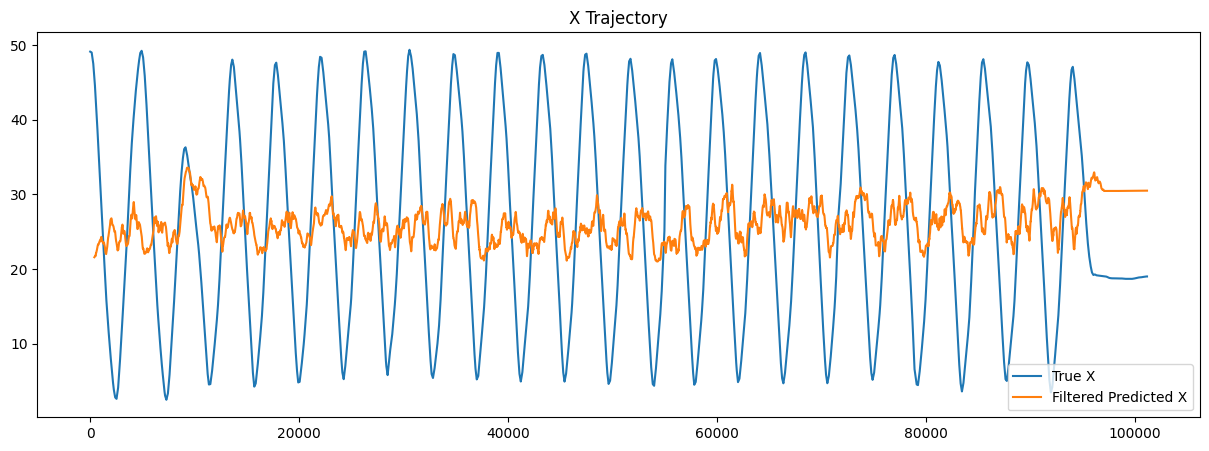

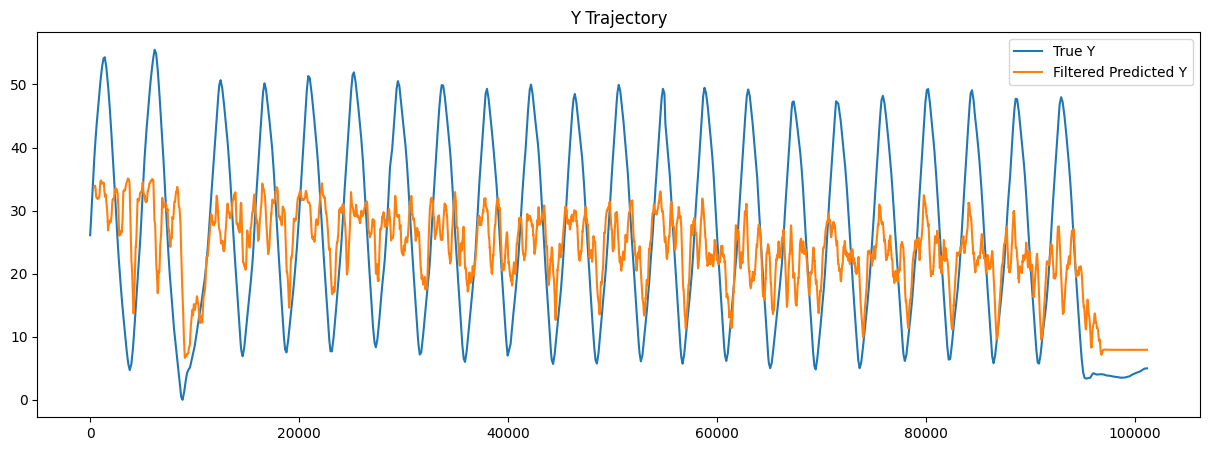

In [5]:
from sklearn.metrics import mean_squared_error
# Load the model and test it
loaded_model = load_model('trajectory_model7i.h5')

# Predict using the test data
y_pred = loaded_model.predict(X_test)

# Calculate the RMSE
rmse_before_filter = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE before filtering: {rmse_before_filter}')

# Apply a moving average filter to the predicted data
def moving_average(data, window_size=400):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average filter to each predicted dimension separately
y_pred_filtered = np.array([moving_average(y_pred[:, i]) for i in range(y_pred.shape[1])]).T

# Align the test data to match the length of the filtered predictions
y_test_aligned = y_test[len(y_test) - len(y_pred_filtered):]

# Calculate the RMSE again after filtering
rmse_after_filter = np.sqrt(mean_squared_error(y_test_aligned, y_pred_filtered))
print(f'RMSE after filtering: {rmse_after_filter}')

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
#plt.plot(y_pred[:, 0], label='Predicted X')
plt.plot(np.arange(len(y_test) - len(y_pred_filtered), len(y_test)), y_pred_filtered[:, 0], label='Filtered Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
#plt.plot(y_pred[:, 1], label='Predicted Y')
plt.plot(np.arange(len(y_test) - len(y_pred_filtered), len(y_test)), y_pred_filtered[:, 1], label='Filtered Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()

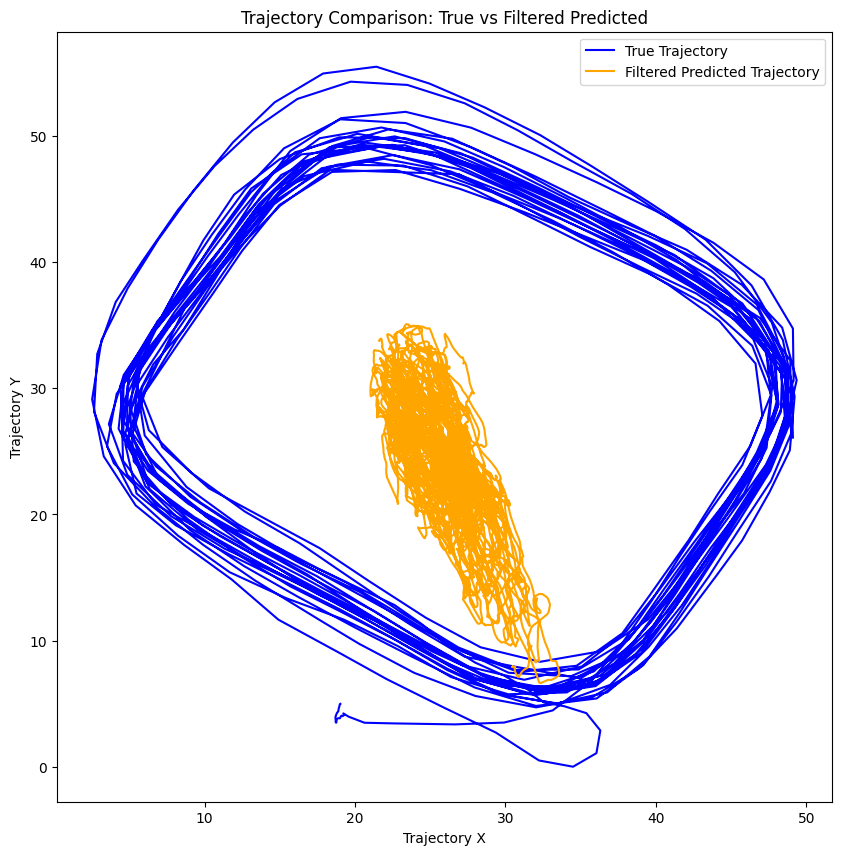

In [6]:
# Plot the results
plt.figure(figsize=(10, 10))

# Plot True Trajectory
plt.plot(y_test[:, 0], y_test[:, 1], label='True Trajectory', color='blue')

# Plot Filtered Predicted Trajectory
plt.plot(y_pred_filtered[:, 0], y_pred_filtered[:, 1], label='Filtered Predicted Trajectory', color='orange')

plt.legend()
plt.xlabel('Trajectory X')
plt.ylabel('Trajectory Y')
plt.title('Trajectory Comparison: True vs Filtered Predicted')
plt.show()

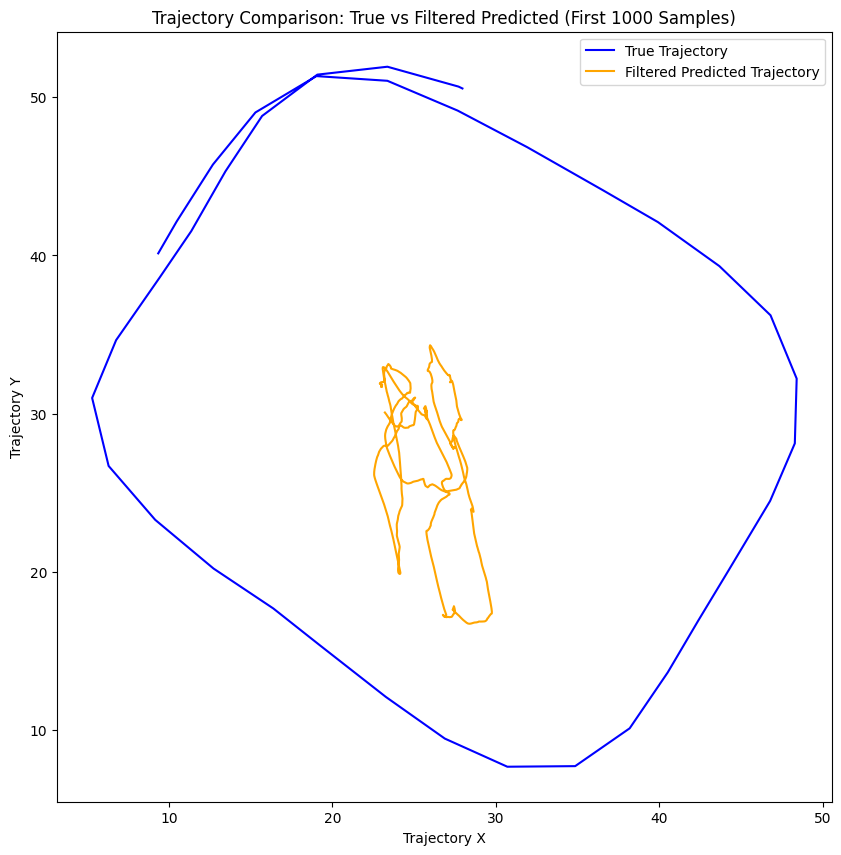

In [7]:
# Select the first 1000 samples for plotting
num_samples = 25000
y_test_samples = y_test_aligned[20000:num_samples]
y_pred_samples = y_pred_filtered[20000:num_samples]

# Plot the results
plt.figure(figsize=(10, 10))

# Plot True Trajectory
plt.plot(y_test_samples[:, 0], y_test_samples[:, 1], label='True Trajectory', color='blue')

# Plot Filtered Predicted Trajectory
plt.plot(y_pred_samples[:, 0], y_pred_samples[:, 1], label='Filtered Predicted Trajectory', color='orange')

plt.legend()
plt.xlabel('Trajectory X')
plt.ylabel('Trajectory Y')
plt.title('Trajectory Comparison: True vs Filtered Predicted (First 1000 Samples)')
plt.show()

3162/3162 [==============================] - 21s 6ms/step
RMSE before filtering: 14.246906003984227
RMSE after filtering and scaling: 13.503672880415175


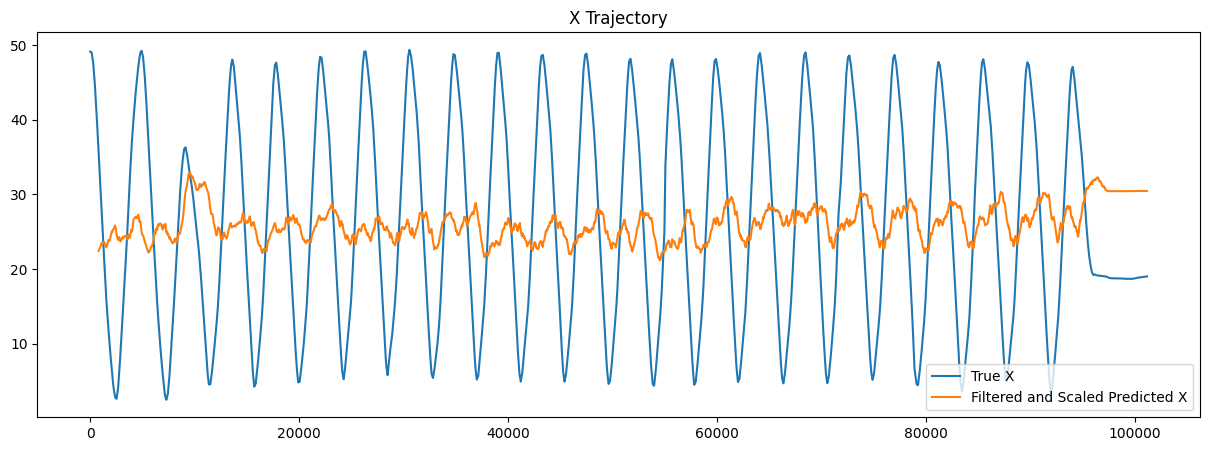

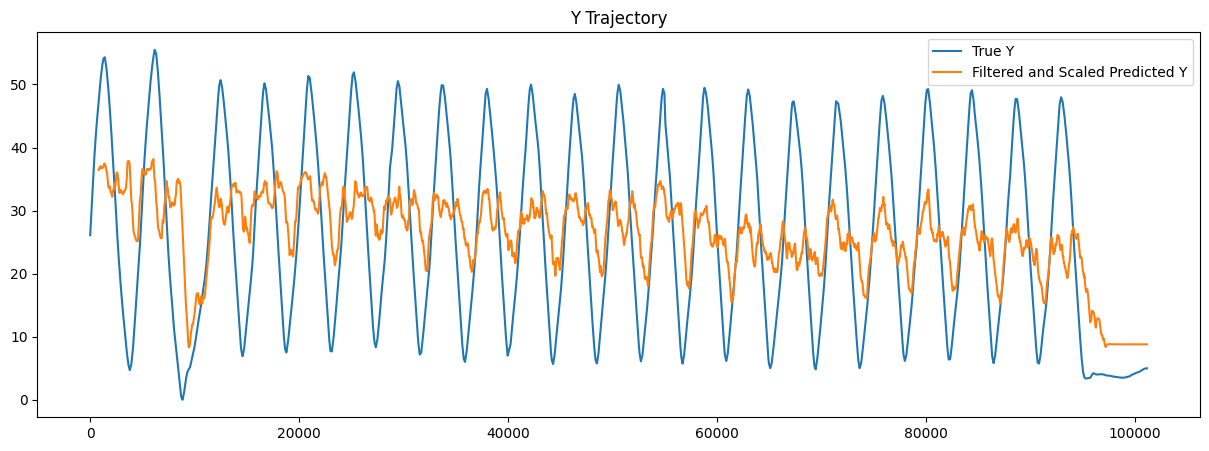

In [8]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the model and test it
loaded_model = load_model('trajectory_model7i.h5')

# Predict using the test data
y_pred = loaded_model.predict(X_test)

# Calculate the RMSE
rmse_before_filter = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE before filtering: {rmse_before_filter}')

# Apply a moving average filter to the predicted data
def moving_average(data, window_size=800):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average filter to each predicted dimension separately
y_pred_filtered = np.array([moving_average(y_pred[:, i]) for i in range(y_pred.shape[1])]).T

# Align the test data to match the length of the filtered predictions
y_test_aligned = y_test[len(y_test) - len(y_pred_filtered):]

# Calculate scaling factors
scaling_factors = np.mean(y_test_aligned, axis=0) / np.mean(y_pred_filtered, axis=0)

# Apply scaling factors to the filtered predicted data
y_pred_scaled = y_pred_filtered * scaling_factors

# Calculate the RMSE again after filtering and scaling
rmse_after_filter_and_scaling = np.sqrt(mean_squared_error(y_test_aligned, y_pred_scaled))
print(f'RMSE after filtering and scaling: {rmse_after_filter_and_scaling}')

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
plt.plot(np.arange(len(y_test) - len(y_pred_scaled), len(y_test)), y_pred_scaled[:, 0], label='Filtered and Scaled Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
plt.plot(np.arange(len(y_test) - len(y_pred_scaled), len(y_test)), y_pred_scaled[:, 1], label='Filtered and Scaled Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()


RMSE after filtering and scaling: 15.999957813438959


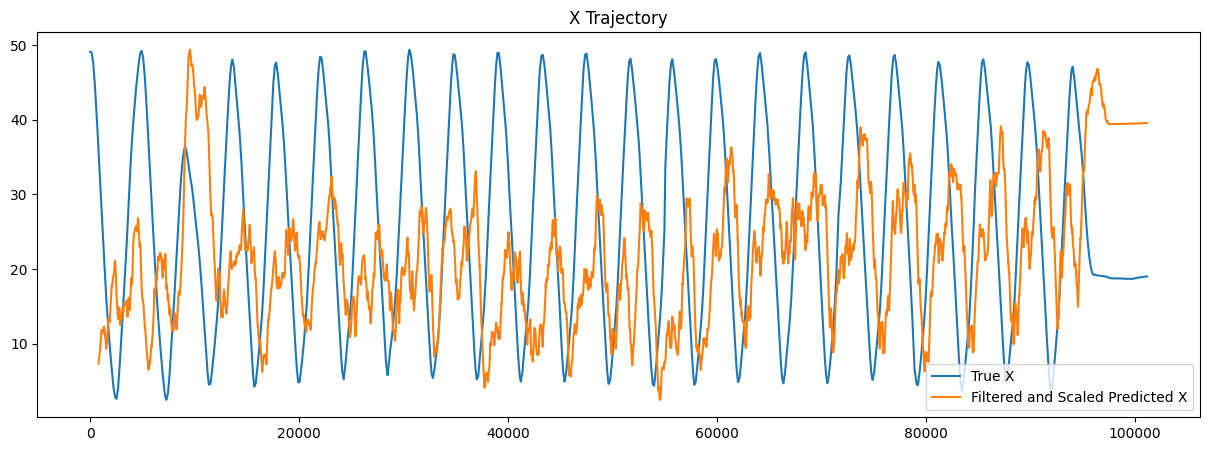

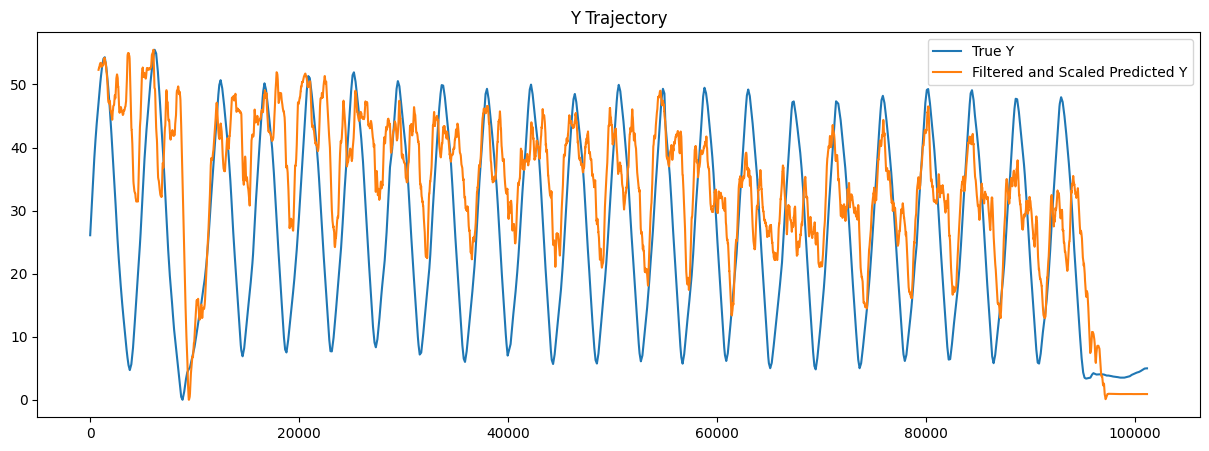

In [9]:
# Calculate min and max values of the true and filtered predicted data
min_true = np.min(y_test_aligned, axis=0)
max_true = np.max(y_test_aligned, axis=0)
min_pred_filtered = np.min(y_pred_filtered, axis=0)
max_pred_filtered = np.max(y_pred_filtered, axis=0)

# Apply min-max scaling to the filtered predicted data
y_pred_scaled = (y_pred_filtered - min_pred_filtered) / (max_pred_filtered - min_pred_filtered) * (max_true - min_true) + min_true

# Calculate the RMSE again after filtering and scaling
rmse_after_filter_and_scaling = np.sqrt(mean_squared_error(y_test_aligned, y_pred_scaled))
print(f'RMSE after filtering and scaling: {rmse_after_filter_and_scaling}')

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
plt.plot(np.arange(len(y_test) - len(y_pred_scaled), len(y_test)), y_pred_scaled[:, 0], label='Filtered and Scaled Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
plt.plot(np.arange(len(y_test) - len(y_pred_scaled), len(y_test)), y_pred_scaled[:, 1], label='Filtered and Scaled Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()

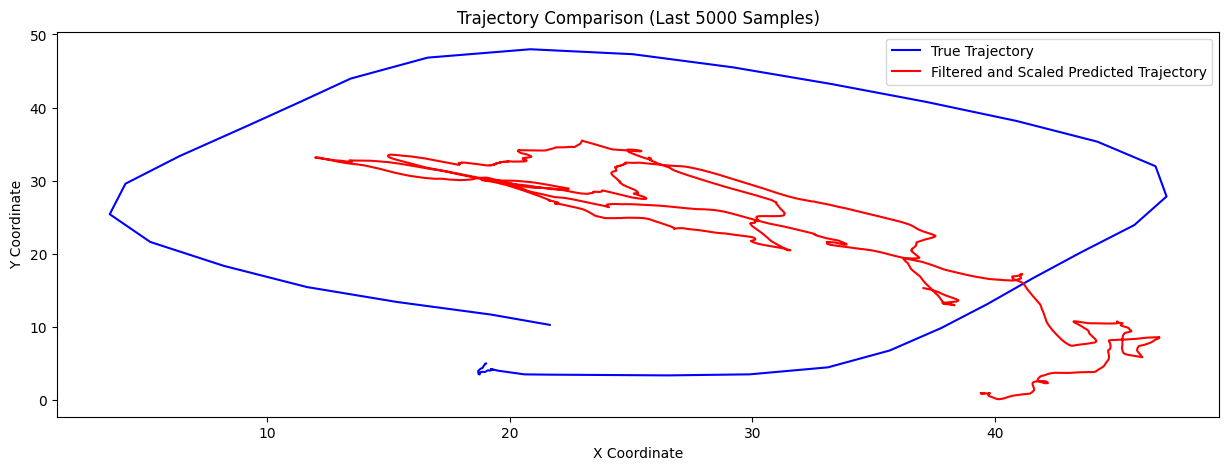

In [10]:
# Select the last 5000 samples
y_test_last_5000 = y_test_aligned[-10000:]
y_pred_scaled_last_5000 = y_pred_scaled[-10000:]

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test_last_5000[:, 0], y_test_last_5000[:, 1], label='True Trajectory', color='blue')
plt.plot(y_pred_scaled_last_5000[:, 0], y_pred_scaled_last_5000[:, 1], label='Filtered and Scaled Predicted Trajectory', color='red')
plt.legend()
plt.title('Trajectory Comparison (Last 5000 Samples)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

Scaling factors: [8.30236253 3.28515399]
Shift values: [-190.60897726  -51.90837025]
Lags: X=-6096, Y=-1020
RMSE after filtering, scaling, shifting, and lag correction: 18.81621662161713


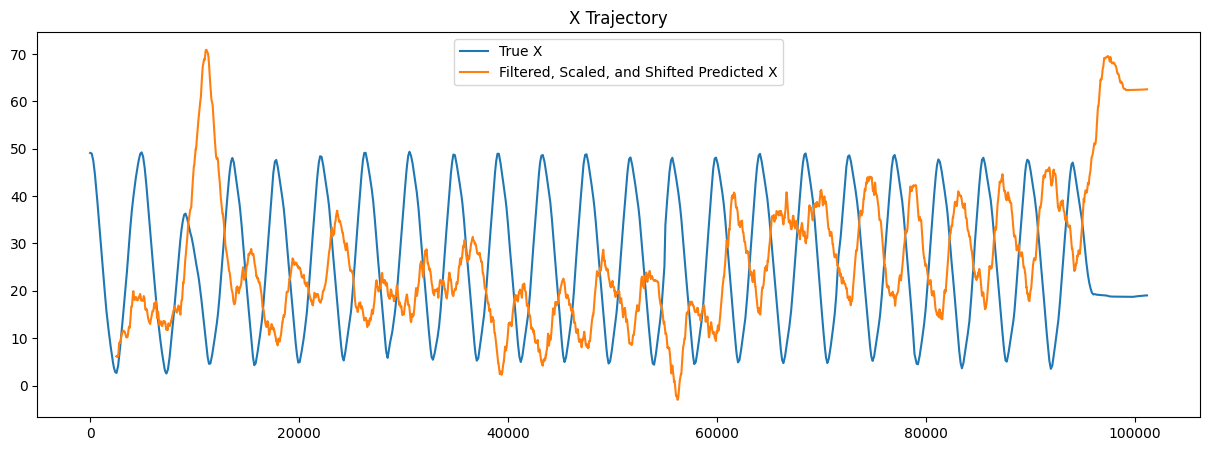

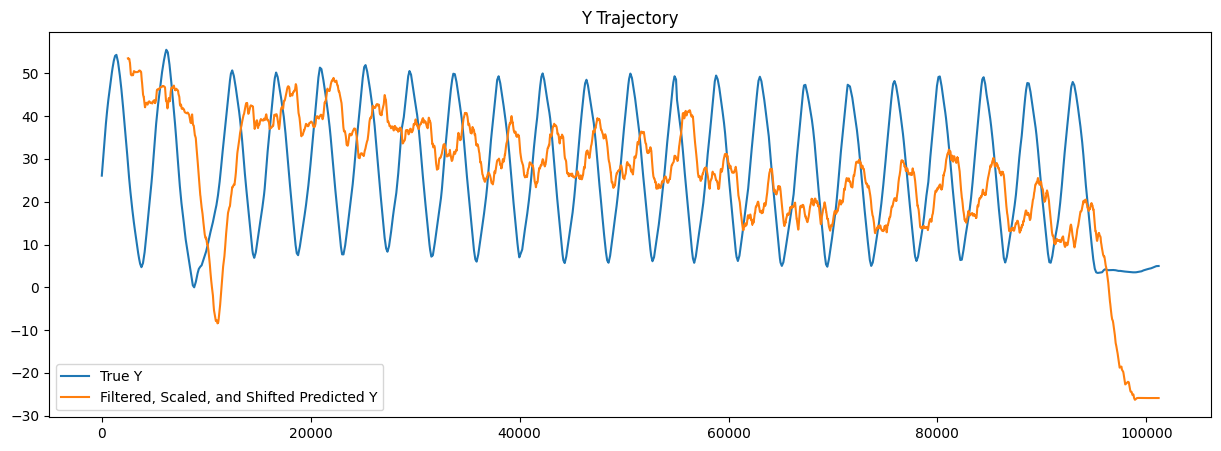

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.signal import correlate

# Apply a moving average filter to the predicted data
def moving_average(data, window_size=2500):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average filter to each predicted dimension separately
y_pred_filtered = np.array([moving_average(y_pred[:, i]) for i in range(y_pred.shape[1])]).T

# Align the test data to match the length of the filtered predictions
y_test_aligned = y_test[len(y_test) - len(y_pred_filtered):]

# Calculate scaling factors using standard deviation
scaling_factors = np.std(y_test_aligned, axis=0) / np.std(y_pred_filtered, axis=0)

# Apply scaling factors to the filtered predicted data
y_pred_scaled = y_pred_filtered * scaling_factors

# Calculate the mean of the aligned ground truth and scaled predictions
mean_y_test = np.mean(y_test_aligned, axis=0)
mean_y_pred = np.mean(y_pred_scaled, axis=0)

# Calculate the shift required to align the means
shift = mean_y_test - mean_y_pred

# Apply the shift to the scaled predicted data
y_pred_scaled_shifted = y_pred_scaled + shift

# Determine the lag that maximizes the cross-correlation between the ground truth and the predicted data
def find_best_shift(y_true, y_pred):
    correlation = correlate(y_true, y_pred)
    lag = correlation.argmax() - (len(y_pred) - 1)
    return lag

# Apply the best shift for each dimension
lag_x = find_best_shift(y_test_aligned[:, 0], y_pred_scaled_shifted[:, 0])
lag_y = find_best_shift(y_test_aligned[:, 1], y_pred_scaled_shifted[:, 1])

# Shift the predicted data
y_pred_final = np.roll(y_pred_scaled_shifted, shift=(lag_x, lag_y), axis=(0, 1))

# Print the used scaling factors, shift values, and lag values
print(f'Scaling factors: {scaling_factors}')
print(f'Shift values: {shift}')
print(f'Lags: X={lag_x}, Y={lag_y}')

# Calculate the RMSE again after filtering, scaling, shifting, and lag correction
rmse_final = np.sqrt(mean_squared_error(y_test_aligned, y_pred_final))
print(f'RMSE after filtering, scaling, shifting, and lag correction: {rmse_final}')

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
plt.plot(np.arange(len(y_test) - len(y_pred_scaled_shifted), len(y_test)), y_pred_scaled_shifted[:, 0], label='Filtered, Scaled, and Shifted Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
plt.plot(np.arange(len(y_test) - len(y_pred_scaled_shifted), len(y_test)), y_pred_scaled_shifted[:, 1], label='Filtered, Scaled, and Shifted Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()


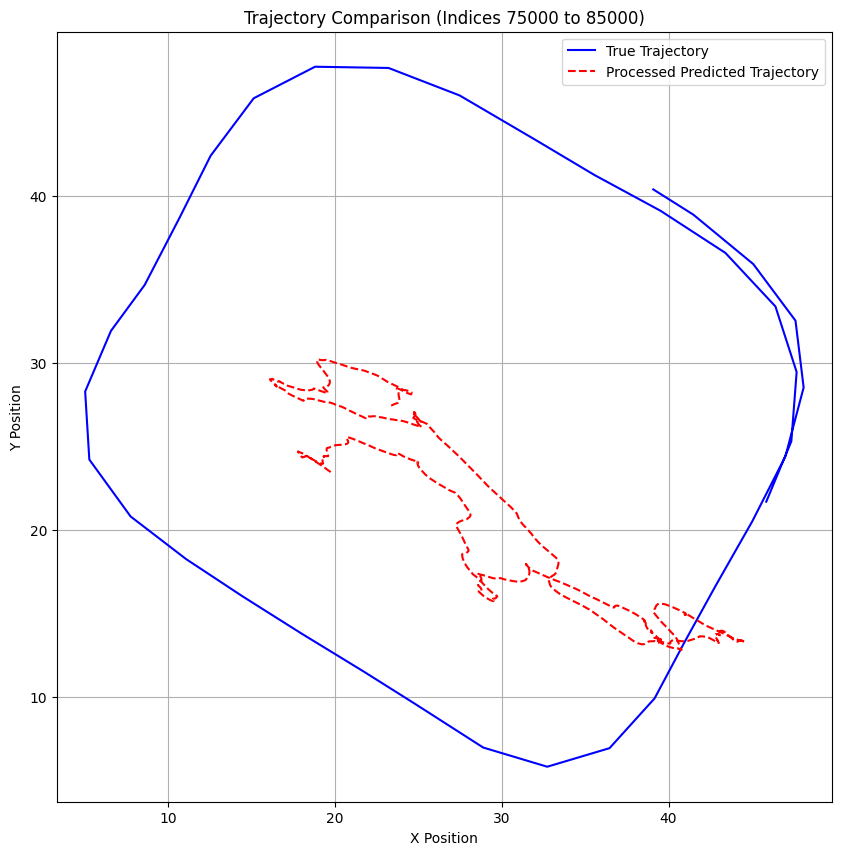

In [32]:

# Define the range of indices to plot
start_index = 85000
end_index = 90000

# Adjust the range to match the length of the aligned data
adjusted_start_index = max(0, start_index - (len(y_test) - len(y_test_aligned)))
adjusted_end_index = min(len(y_test_aligned), end_index - (len(y_test) - len(y_test_aligned)))

# Plot the results for both X and Y trajectories on the same plot
plt.figure(figsize=(10, 10))
plt.plot(y_test_aligned[adjusted_start_index:adjusted_end_index, 0], y_test_aligned[adjusted_start_index:adjusted_end_index, 1], label='True Trajectory', color='blue')
plt.plot(y_pred_scaled_shifted[adjusted_start_index:adjusted_end_index, 0], y_pred_scaled_shifted[adjusted_start_index:adjusted_end_index, 1], label='Processed Predicted Trajectory', color='red', linestyle='dashed')
plt.legend()
plt.title('Trajectory Comparison (Indices 75000 to 85000)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.grid(True)
plt.show()

Scaling factors: [13.73524987  8.08062981]
Shift values: [-335.88239274 -154.65063286]
Lags: X=-1629, Y=-870


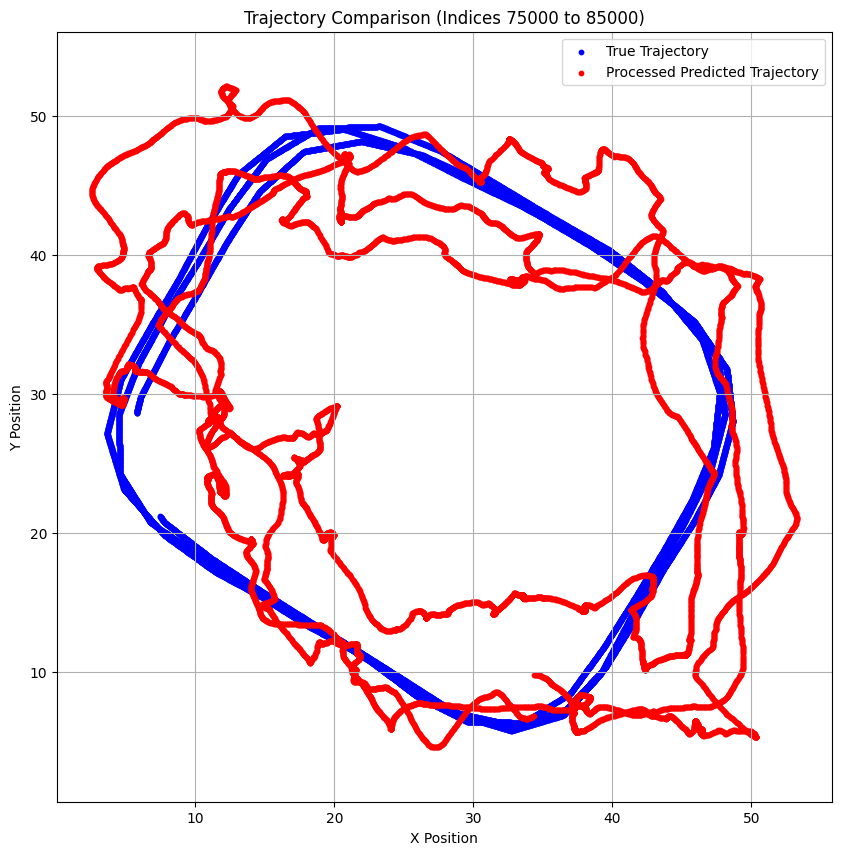

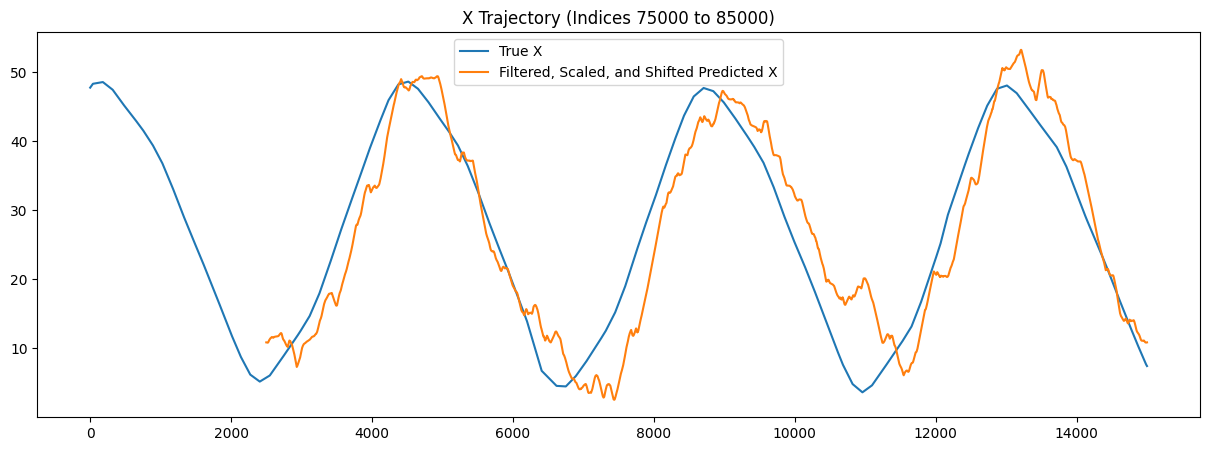

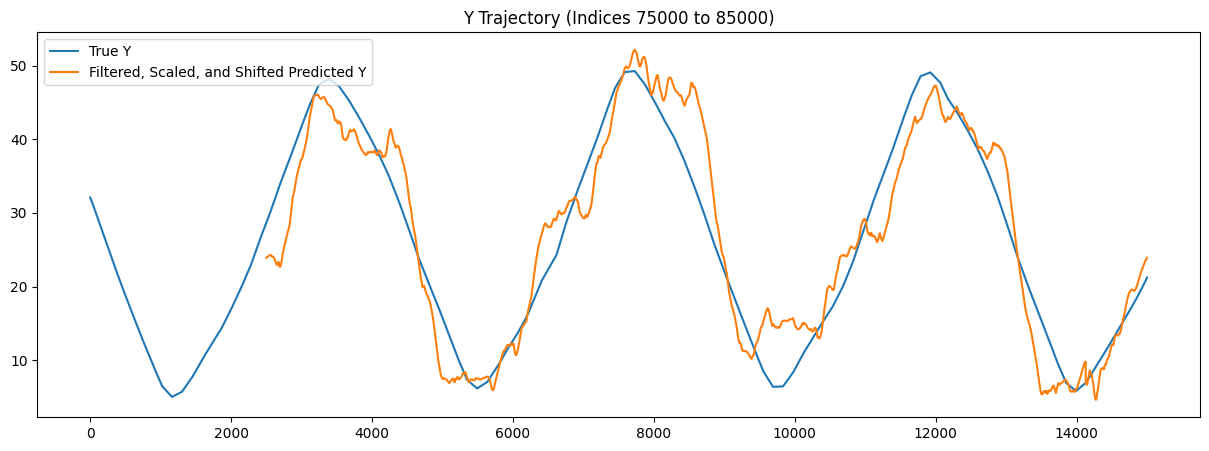

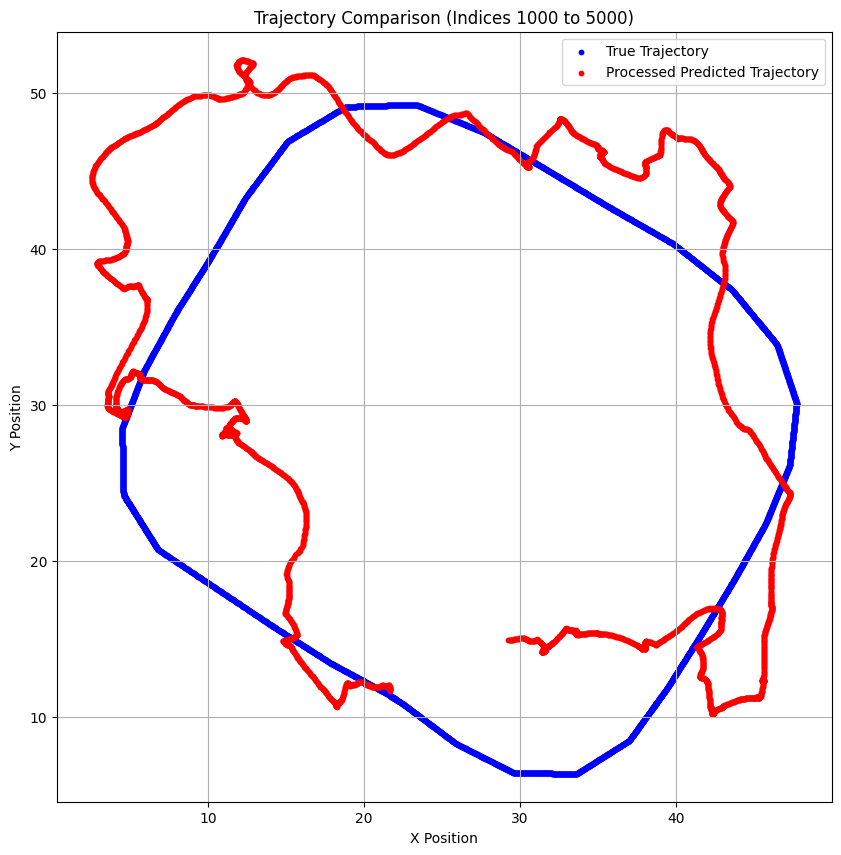

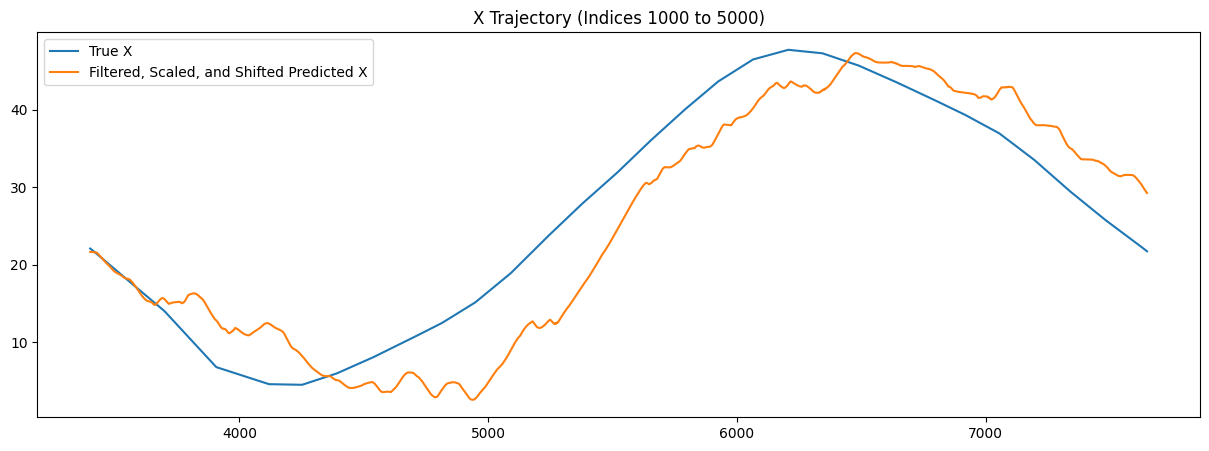

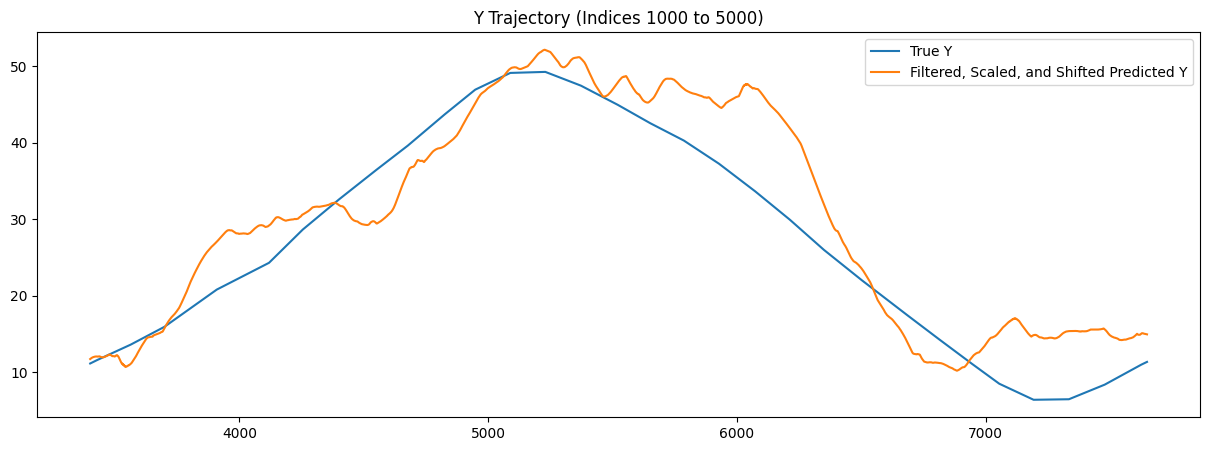

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.signal import correlate
import pandas as pd

# Function to apply a moving average filter to the predicted data
def moving_average(data, window_size=2500):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Define the range of indices to use for processing
start_index = 72500
end_index = 87500

# Cut the data to only use the specified range for processing
y_test_cut = y_test[start_index:end_index]
y_pred_cut = y_pred[start_index:end_index]

# Apply moving average filter to each predicted dimension separately
y_pred_filtered = np.array([moving_average(y_pred_cut[:, i]) for i in range(y_pred_cut.shape[1])]).T

# Align the test data to match the length of the filtered predictions
y_test_aligned = y_test_cut[len(y_test_cut) - len(y_pred_filtered):]

# Calculate scaling factors using standard deviation
scaling_factors = np.std(y_test_aligned, axis=0) / np.std(y_pred_filtered, axis=0)

# Apply scaling factors to the filtered predicted data
y_pred_scaled = y_pred_filtered * scaling_factors

# Calculate the mean of the aligned ground truth and scaled predictions
mean_y_test = np.mean(y_test_aligned, axis=0)
mean_y_pred = np.mean(y_pred_scaled, axis=0)

# Calculate the shift required to align the means
shift = mean_y_test - mean_y_pred

# Apply the shift to the scaled predicted data
y_pred_scaled_shifted = y_pred_scaled + shift

# Determine the lag that maximizes the cross-correlation between the ground truth and the predicted data
def find_best_shift(y_true, y_pred):
    correlation = correlate(y_true, y_pred)
    lag = correlation.argmax() - (len(y_pred) - 1)
    return lag

# Apply the best shift for each dimension
lag_x = find_best_shift(y_test_aligned[:, 0], y_pred_scaled_shifted[:, 0])
lag_y = find_best_shift(y_test_aligned[:, 1], y_pred_scaled_shifted[:, 1])

# Create copies of the data to apply the shifts
y_pred_final_x = np.roll(y_pred_scaled_shifted[:, 0], shift=lag_x)
y_pred_final_y = np.roll(y_pred_scaled_shifted[:, 1], shift=lag_y)

# Combine the shifted dimensions back into a single array
y_pred_final = np.column_stack((y_pred_final_x, y_pred_final_y))

# Print the used scaling factors, shift values, and lag values
print(f'Scaling factors: {scaling_factors}')
print(f'Shift values: {shift}')
print(f'Lags: X={lag_x}, Y={lag_y}')

# Store the data in temp.csv
df = pd.DataFrame({
    'True_X': y_test_aligned[:, 0],
    'True_Y': y_test_aligned[:, 1],
    'Pred_X': y_pred_final[:, 0],
    'Pred_Y': y_pred_final[:, 1]
})
df.to_csv('temp.csv', index=False)

# Load the data from temp.csv
df = pd.read_csv('temp.csv')

# Extract the required range of samples
plot_data = df.iloc[3400:7650]

# Original plots
# Plot the results for both X and Y trajectories on the same plot as dots (75,000 to 85,000)
plt.figure(figsize=(10, 10))
plt.scatter(y_test_aligned[:, 0], y_test_aligned[:, 1], label='True Trajectory', color='blue', s=10)
plt.scatter(y_pred_final[:, 0], y_pred_final[:, 1], label='Processed Predicted Trajectory', color='red', s=10)
plt.legend()
plt.title('Trajectory Comparison (Indices 75000 to 85000)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.grid(True)
plt.show()

# Separate plots for X and Y trajectories (75,000 to 85,000)
plt.figure(figsize=(15, 5))
plt.plot(y_test_cut[:, 0], label='True X')
plt.plot(np.arange(len(y_test_cut) - len(y_pred_final), len(y_test_cut)), y_pred_final[:, 0], label='Filtered, Scaled, and Shifted Predicted X')
plt.legend()
plt.title('X Trajectory (Indices 75000 to 85000)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test_cut[:, 1], label='True Y')
plt.plot(np.arange(len(y_test_cut) - len(y_pred_final), len(y_test_cut)), y_pred_final[:, 1], label='Filtered, Scaled, and Shifted Predicted Y')
plt.legend()
plt.title('Y Trajectory (Indices 75000 to 85000)')
plt.show()

# New plots
# Plot the results for both X and Y trajectories on the same plot as dots (1000th to 5000th sample)
plt.figure(figsize=(10, 10))
plt.scatter(plot_data['True_X'], plot_data['True_Y'], label='True Trajectory', color='blue', s=10)
plt.scatter(plot_data['Pred_X'], plot_data['Pred_Y'], label='Processed Predicted Trajectory', color='red', s=10)
plt.legend()
plt.title('Trajectory Comparison (Indices 1000 to 5000)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.grid(True)
plt.show()

# Separate plots for X and Y trajectories (1000th to 5000th sample)
plt.figure(figsize=(15, 5))
plt.plot(plot_data['True_X'], label='True X')
plt.plot(plot_data['Pred_X'], label='Filtered, Scaled, and Shifted Predicted X')
plt.legend()
plt.title('X Trajectory (Indices 1000 to 5000)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(plot_data['True_Y'], label='True Y')
plt.plot(plot_data['Pred_Y'], label='Filtered, Scaled, and Shifted Predicted Y')
plt.legend()
plt.title('Y Trajectory (Indices 1000 to 5000)')
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the file paths
train_files = ['own/data-int/1.csv', 'own/data-int/2.csv', 'own/data-int/4.csv']
validation_test_file = 'own/data-int/6.csv'

# Function to load and preprocess data
def load_and_preprocess_data(train_files, validation_test_file):
    # Load the training data
    train_dfs = [pd.read_csv(file) for file in train_files]
    
    # Load the validation and test data
    validation_test_df = pd.read_csv(validation_test_file)
    
    # Convert 'date/time' columns to datetime
    for df in train_dfs:
        df['datetime'] = pd.to_datetime(df['date/time'], errors='coerce')
    validation_test_df['datetime'] = pd.to_datetime(validation_test_df['date/time'], errors='coerce')
    
    # Process each training dataframe
    processed_train_dfs = []
    for df, file in zip(train_dfs, train_files):
        if '1.csv' in file:
            # Remove the first 1 minute and the last 3 minutes from the first training data (1.csv)
            train_start_time = df['datetime'].min() + pd.Timedelta(minutes=1)
            train_end_time = df['datetime'].max() - pd.Timedelta(minutes=3)
        elif '2.csv' in file:
            # Remove the first 3 minutes and the last 2.5 minutes from the second training data (2.csv)
            train_start_time = df['datetime'].min() + pd.Timedelta(minutes=3)
            train_end_time = df['datetime'].max() - pd.Timedelta(minutes=2.5)
        else:
            # Remove the first and last 3 minutes from the other training data (6.csv)
            train_start_time = df['datetime'].min() + pd.Timedelta(minutes=3)
            train_end_time = df['datetime'].max() - pd.Timedelta(minutes=3)
        processed_df = df[(df['datetime'] >= train_start_time) & (df['datetime'] <= train_end_time)]
        processed_train_dfs.append(processed_df)
    
    # Concatenate all processed training dataframes
    train_df = pd.concat(processed_train_dfs, ignore_index=True)
    
    # Split validation_test_df into validation and test sets
    mid_index = len(validation_test_df) // 2
    val_df = validation_test_df.iloc[:mid_index]
    test_df = validation_test_df
    
    return train_df, val_df, test_df

# Load datasets
train_df, val_df, test_df = load_and_preprocess_data(train_files, validation_test_file)

print('Loading complete')
train_df.head(), val_df.head(), test_df.head()


2024-06-27 11:37:02.684080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 11:37:03.407209: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-27 11:37:03.407363: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-

Loading complete


(                    date/time     gyro_x    gyro_y    gyro_z   accel_x  \
 0  2024-06-05 14:09:12.810708  47.229008  1.580153  4.488550  0.464475   
 1  2024-06-05 14:09:12.818031  47.030534  0.419847  5.343511 -0.964863   
 2  2024-06-05 14:09:12.824984  47.328244 -4.145038  6.557252 -0.799663   
 3  2024-06-05 14:09:12.832316  48.068702 -3.725191  6.763359  1.841141   
 4  2024-06-05 14:09:12.839155  47.679389 -1.847328  6.595420  3.287239   
 
     accel_y    accel_z          x          y                   timestamp  \
 0  0.493206   7.393295  24.801591  53.530177  2024-06-05 14:09:12.810708   
 1  0.105345   7.541735  24.776822  53.538791  2024-06-05 14:09:12.818031   
 2  0.849942   8.384494  24.752052  53.547405  2024-06-05 14:09:12.824984   
 3  0.289698  10.572795  24.727283  53.556018  2024-06-05 14:09:12.832316   
 4  0.694318  11.298238  24.702514  53.564632  2024-06-05 14:09:12.839155   
 
       x_cam     y_cam     z_cam                   datetime  
 0  0.469269 -0.780899